by [Hammani Elasri Elkamali]

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

## Load Data

In [2]:
import cifar10

In [3]:
class_names = cifar10.load_class_names()
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: /home/hidiki/Desktop/PROJECT/data/CIFAR-10/cifar-10-batches-py/test_batch


In [4]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Data Dimensions

In [5]:
from cifar10 import img_size, num_channels, num_classes

In [6]:
img_size_cropped = 24

### Placeholder variables

In [7]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Helper-function for creating Pre-Processing

In [8]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        
        image = tf.image.resize_image_with_crop_or_pad(image,target_height=img_size_cropped,target_width=img_size_cropped)
        
    return image

In [9]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

### Helper-function for creating Main Processing

In [10]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=3, depth=64, name='layer_conv2', batch_normalize=True).\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=512, name='layer_fc1').\
        fully_connected(size=256, name='layer_fc2').\
        fully_connected(size=128, name='layer_fc3').\
        softmax_classifier(num_classes=num_classes, labels=y_true)
    return y_pred, loss
#(N-F)/S+1 output size!

### Helper-function for creating Neural Network

The following helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above.

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [11]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase

In [12]:
global_step = tf.Variable(initial_value=0,name='global_step', trainable=False)
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
#loss_scalar=tf.scalar_summary("loss",loss)


### Create Neural Network for Test Phase / Inference

In [13]:
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [14]:
saver = tf.train.Saver()

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [15]:
session = tf.Session()

In [16]:
#for tensorboard
#writer=tf.train.SummaryWriter("logs",session.graph)

### Restore or initialize variables

In [17]:
save_dir = 'checkpoints/'

In [18]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [19]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [20]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
Restored checkpoint from: checkpoints/cifar10_cnn-306000


### Helper-function to get a random training-batch

There are 50,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [21]:
train_batch_size = 64

Function for selecting a random batch of images from the training-set.

In [22]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,size=train_batch_size,replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Helper-function to perform optimization

In [23]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch,y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer],feed_dict=feed_dict_train)

        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy,feed_dict=feed_dict_train)

            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>5.2%}"
            print(msg.format(i_global, batch_acc))

        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session,save_path=save_path,global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [24]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [25]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [26]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.float32)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [27]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [28]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [29]:
def print_test_accuracy(show_example_errors=False,show_confusion_matrix=False):
    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.2%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Perform optimization

My laptop computer (DELL) is a Quad-Core with 2 GHz per core. It has a GPU but it is not fast enough for TensorFlow so it only uses the CPU. It takes about 3h45min to perform 30,000 optimization iterations using the CPU on this PC.

Because we are saving the checkpoints during optimization, and because we are restoring the latest checkpoint when restarting the code, we can stop and continue the optimization later.

In [ ]:
if True:
    optimize(num_iterations=100000)

## Results

After 150,000 optimization iterations, the classification accuracy is about 79-80% on the test-set. Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

In [40]:
print_test_accuracy()

Accuracy on Test-Set: 81.62% (8162 / 10000)


In [32]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

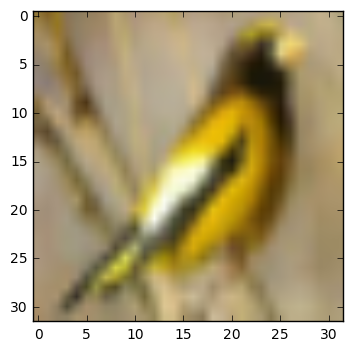

In [33]:
img, cls = get_test_image(182)
plt.imshow(img)

In [34]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],feed_dict={x: [img]})

In [35]:
np.set_printoptions(precision=4, suppress=True)

# Print the predicted label.
print(label_pred[0])
print("le max:",max(label_pred[0]))
print(class_names[cls_pred[0]])
print(img.dtype)
print(type(img))
print("miin :",img.min())
print("maax :",img.max())
#print(img)

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
le max: 0.999958
bird
float64
<class 'numpy.ndarray'>
miin : 0.0
maax : 0.996078431373


# Function to test one image

In [36]:
def plot_originalImg_and_32pImg(original_Img,Img32):
    plt.rcParams['figure.figsize'] = (10.0,10.0)

    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    ax0.imshow(original_Img)
    ax1.imshow(Img32)

    # Set labels.
    ax0.set_xlabel('original image')
    ax1.set_xlabel('image after processing')
    plt.show()

In [37]:
def predict_one_image(image):
    prediction ,indice = session.run([y_pred, y_pred_cls],feed_dict={x: [image]})
    return prediction[0],indice[0]

the original size : (0, 0, 2400, 1600)
size after crop (0, 0, 1600, 1600)
size after thumbnail : (0, 0, 32, 32)


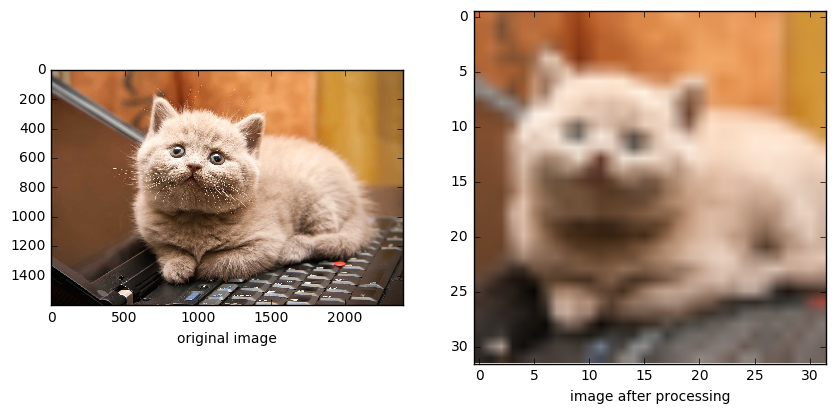

NameError: name 'normalize' is not defined

In [38]:
#import an image from your machine!!
from PIL import Image

size32 = (32,32)

myImage = Image.open("images/cat2.jpg")

print("the original size :",myImage.getbbox())  #the original size of the image
original=myImage.copy()

w,h = myImage.size
if w==h:
    myImage.thumbnail(size32)
    print("size after thumbnail",myImage.getbbox())
    lastImg=myImage.copy()
elif w>h:
    diff=w-h
    d=int(diff/2)
    lastImg=myImage.crop((d,0,d+h,h)).copy()
    print("size after crop",lastImg.getbbox())
    lastImg.thumbnail(size32)
    print("size after thumbnail :",lastImg.getbbox())
else:
    diff=h-w
    d=int(diff/2)
    lastImg=myImage.crop((0,d,w,d+w)).copy()
    print("size after crop",lastImg.getbbox())
    lastImg.thumbnail(size32)
    print("size after thumbnail :",lastImg.getbbox())

plot_originalImg_and_32pImg(original,lastImg)

Img = np.asarray(lastImg,dtype=np.float64)

Img=normalize(Img)

print(Img.dtype)
print(type(Img))
print(Img.max())
print(Img.min())
print(Img)
#print(Img)


In [ ]:
try:
    _vect,index = predict_one_image(Img)
    plt.rcParams['figure.figsize'] = (2.0,2.0)
    plt.title(class_names[index])
    plt.imshow(Img)
except ValueError:
    print("There is a problem !")

In [ ]:
np.set_printoptions(precision=4, suppress=True)
print(_vect)

In [ ]:
np.set_printoptions(precision=3, suppress=False)
t = np.copy(_vect)
print("{:.2f} % {}".format(t.max()*100,class_names[np.argmax(t)]))
t[np.argmax(t)]=-1
print("{:.2f} % {}".format(t.max()*100,class_names[np.argmax(t)]))
t[np.argmax(t)]=-1
print("{:.2f} % {}".format(t.max()*100,class_names[np.argmax(t)]))
np.set_printoptions(precision=3, suppress=False)
print(_vect)

In [ ]:
def normalize(array):
    newArray = array / 255.0
    return newArray

#test
arr = np.array([1,100,200,245])
arr = normalize(arr)
print(arr)
print("first max :",arr.max())



## Close TensorFlow Session

In [ ]:
#session.close()